## Initial Setup

In [1]:
!nvidia-smi

Sun Mar  7 13:54:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [2]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Importing Tensorflow

In [1]:
import tensorflow as tf
tf.random.set_seed(42)

print(tf.__version__)

2.4.1


## Importing necessary modules

In [2]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import re 

import numpy as np
np.random.seed(42)

## Data Parsing

In [3]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/27_Backlight/71.jpg',
 'training/22_Stage_concert/296.jpg',
 'training/11_Snow/336.jpg',
 'training/15_Sunset_Sunrise/96.jpg',
 'training/24_Candle_light/101.jpg']

## Counting number of images for each classes

In [4]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [5]:
TRAIN_SPLIT = 0.9
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
EPOCHS = 100

In [6]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


In [7]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[18 13  1  5 15]


## DataLoader

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

Since the dataset has class imbalance issue, it's good to supply class weights while training the model.

In [9]:
# Reference: https://www.pyimagesearch.com/2019/02/18/breast-cancer-classification-with-keras-and-deep-learning/

trainLabels = to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Set dataset-dependent hyperparameters

In [10]:
IMAGE_SIZE = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 260
  CROP_TO = 224
else:
  RESIZE_TO = 260
  CROP_TO = 224

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

## Preprocessing helper functions

In [11]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function  
def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

@tf.function
def preprocess_test(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.cast(image, tf.float32) / 255.0
    return (image, label)

In [12]:
DATASET_NUM_TRAIN_EXAMPLES=len(train_paths)
NUM_CLASSES=30
STEPS_PER_EPOCH = 140

## Create data pipelines for training and testing:

In [13]:
pipeline_train = (train_ds
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

pipeline_test = (val_ds.map(preprocess_test, num_parallel_calls=1)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

## # Load model into KerasLayer

In [14]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

# module = Sequential([
#     hub.KerasLayer(model_url, trainable=True), 
#     Dense(NUM_CLASSES, kernel_initializer='zeros')
#     ])

## BiT Model

In [15]:
class MyBiTModel(tf.keras.Model):

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

## Defining optimiser and loss

In [16]:
lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.01, lr*0.001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

## Setting the callback

In [18]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

## Training the model

In [19]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    class_weight=classWeight,
    validation_data=pipeline_test,
    callbacks=train_callbacks)

Epoch 1/14
140/140 [==============================] - 360s 2s/step - loss: 1.1844 - accuracy: 0.8109 - val_loss: 0.1188 - val_accuracy: 0.9596
Epoch 2/14
140/140 [==============================] - 312s 2s/step - loss: 0.0672 - accuracy: 0.9871 - val_loss: 0.0973 - val_accuracy: 0.9717
Epoch 3/14
140/140 [==============================] - 312s 2s/step - loss: 0.0350 - accuracy: 0.9952 - val_loss: 0.0951 - val_accuracy: 0.9697
Epoch 4/14
140/140 [==============================] - 312s 2s/step - loss: 0.0334 - accuracy: 0.9960 - val_loss: 0.0951 - val_accuracy: 0.9697
Epoch 5/14
140/140 [==============================] - 313s 2s/step - loss: 0.0322 - accuracy: 0.9966 - val_loss: 0.0950 - val_accuracy: 0.9697
Epoch 6/14
140/140 [==============================] - 312s 2s/step - loss: 0.0326 - accuracy: 0.9961 - val_loss: 0.0949 - val_accuracy: 0.9697
Epoch 7/14
140/140 [==============================] - 312s 2s/step - loss: 0.0341 - accuracy: 0.9953 - val_loss: 0.0949 - val_accuracy: 0.9697

## Plotting the Graph

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Evaluate our Model

8/8 [==============================] - 8s 996ms/step - loss: 0.0973 - accuracy: 0.9717
Accuracy: 97.17%


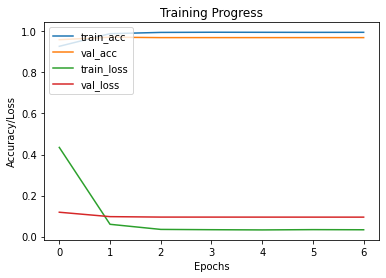

In [21]:
accuracy = model.evaluate(pipeline_test)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(history)

## Saving the Model

In [22]:
model.save('bit_image_scene')

INFO:tensorflow:Assets written to: bit_image_scene/assets


INFO:tensorflow:Assets written to: bit_image_scene/assets


In [23]:
!du -lh bit_image_scene

4.0K	bit_image_scene/assets
180M	bit_image_scene/variables
191M	bit_image_scene


## Inference Pipeline

In [24]:
!wget -q https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_validation.zip
!unzip -qq camera_scene_detection_validation.zip

In [25]:
# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [26]:
test_image_paths = sorted_nicely(list(paths.list_images("images")))
print(f"Total test images: {len(test_image_paths)}")

Total test images: 600


In [27]:
test_image_paths[:5]

['images/0.jpg',
 'images/1.jpg',
 'images/2.jpg',
 'images/3.jpg',
 'images/4.jpg']

In [28]:
classifier_model = load_model("bit_image_scene")

test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

test_predictions = np.argmax(classifier_model.predict(test_ds), 1)
test_predictions = le.inverse_transform(test_predictions)
print(test_predictions.shape)

(600,)


In [29]:
test_predictions_num = list(map(lambda x: x.split("_")[0], test_predictions.tolist()))
print(test_predictions_num[:5])
with open('results.txt', "w") as myfile:
    myfile.write('\n'.join(list(test_predictions_num)))
!head -5 results.txt

['9', '21', '27', '4', '28']
9
21
27
4
28


In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model("bit_image_scene")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS 
]
tflite_model = converter.convert()
open("bit_image_scene.tflite", 'wb').write(tflite_model)
print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

Model size is 23.269440 MBs.


In [31]:
interpreter = tf.lite.Interpreter(model_path = 'bit_image_scene.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 30]
Output Type: <class 'numpy.float32'>
